In [44]:
import tensorflow as tf

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
import shutil
import matplotlib.pyplot as plt
import numpy as np
import time

In [5]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [7]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

61306/61306 [==============================] - 0s 0us/step


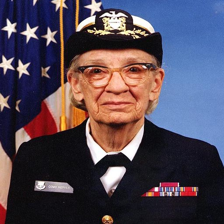

In [8]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [9]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [10]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 [==============================] - 6s 6s/step


(1, 1001)

In [11]:
result

array([[ 0.20035133,  1.0635303 , -0.09429893, ...,  0.1007457 ,
        -0.568068  , -0.07171452]], dtype=float32)

In [12]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

10484/10484 [==============================] - 0s 0us/step


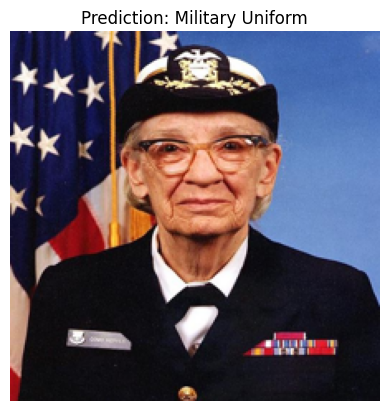

In [13]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

In [40]:
(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [41]:
for i, example_image in enumerate(train_examples.take(3)):
    print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [16]:
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [17]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

1/1 [==============================] - 0s 203ms/step


array(['lynx', 'Egyptian cat', 'tiger cat', 'lynx', 'bucket', 'beagle',
       'American Staffordshire terrier', 'Walker hound',
       'German short-haired pointer', 'Egyptian cat', 'tabby',
       'miniature pinscher', 'Labrador retriever', 'Labrador retriever',
       'English foxhound', 'German shepherd', 'whippet', 'tabby',
       'kelpie', 'kuvasz', 'toy terrier', 'tabby', 'Egyptian cat',
       'Egyptian cat', 'pug', 'bluetick', 'papillon', 'quilt',
       'dalmatian', 'Siamese cat', 'tabby', 'Boston bull'], dtype='<U30')

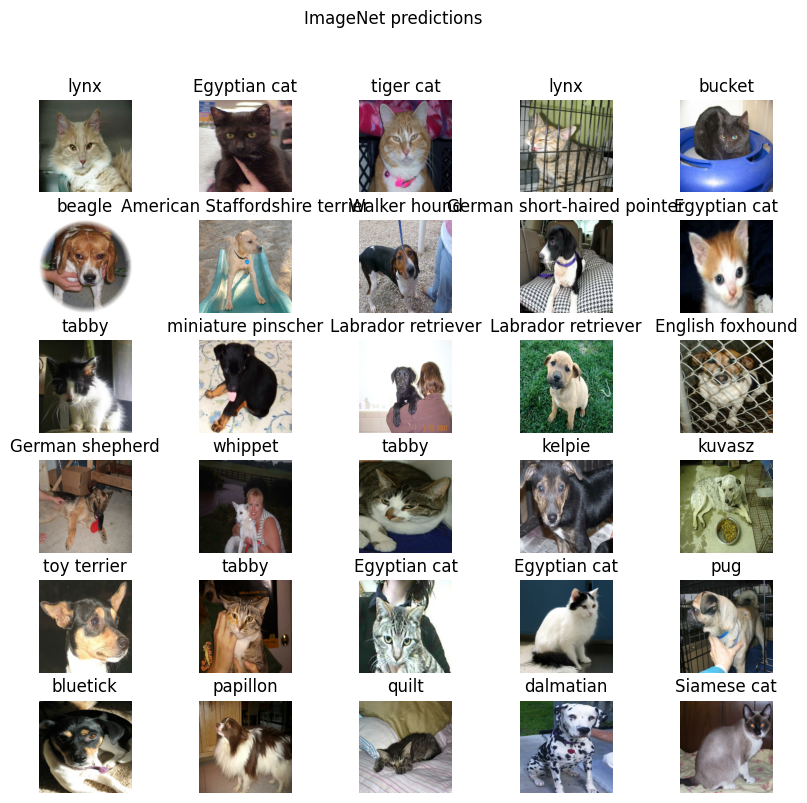

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [19]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [20]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [22]:
feature_extractor.trainable = False

In [23]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [30]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

EPOCHS = 20
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/20
582/582 [==============================] - 21s 32ms/step - loss: 0.0165 - accuracy: 0.9946 - val_loss: 0.0378 - val_accuracy: 0.9880
Epoch 2/20
582/582 [==============================] - 19s 32ms/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0371 - val_accuracy: 0.9893
Epoch 3/20
582/582 [==============================] - 19s 31ms/step - loss: 0.0132 - accuracy: 0.9956 - val_loss: 0.0410 - val_accuracy: 0.9888
Epoch 4/20
582/582 [==============================] - 18s 29ms/step - loss: 0.0124 - accuracy: 0.9962 - val_loss: 0.0355 - val_accuracy: 0.9897
Epoch 5/20
582/582 [==============================] - 22s 35ms/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.0357 - val_accuracy: 0.9897
Epoch 6/20
582/582 [==============================] - 21s 34ms/step - loss: 0.0090 - accuracy: 0.9979 - val_loss: 0.0377 - val_accuracy: 0.9897
Epoch 7/20
582/582 [==============================] - 19s 31ms/step - loss: 0.0099 - accuracy: 0.9968 - val_loss: 0.0375 - val_accuracy:

In [52]:
t = time.time()

export_path_sm = "models/{}".format(int(t))
print(export_path_sm)
tf.saved_model.save(model, export_path_sm)

models/1666099338


In [53]:
reload_sm_keras = tf.keras.models.load_model(
    export_path_sm,
    custom_objects={'KerasLayer': hub.KerasLayer})

reload_sm_keras.summary()

ValueError: Unable to create a Keras model from SavedModel at models/1666099338. This SavedModel was exported with `tf.saved_model.save`, and lacks the Keras metadata file. Please save your Keras model by calling `model.save` or `tf.keras.models.save_model`. Note that you can still load this SavedModel with `tf.saved_model.load`.

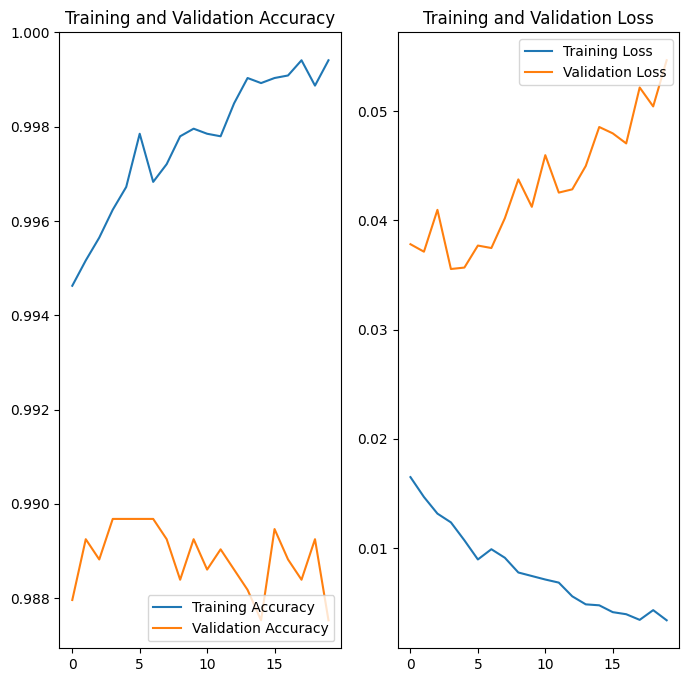

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

In [37]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 [==============================] - 0s 31ms/step


array(['cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog',
       'cat', 'cat', 'dog', 'dog', 'dog', 'dog', 'dog', 'dog', 'cat',
       'dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog',
       'cat', 'dog', 'cat', 'cat', 'dog'], dtype='<U3')

In [38]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1]
Predicted labels:  [0 0 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 1 0 0 1]


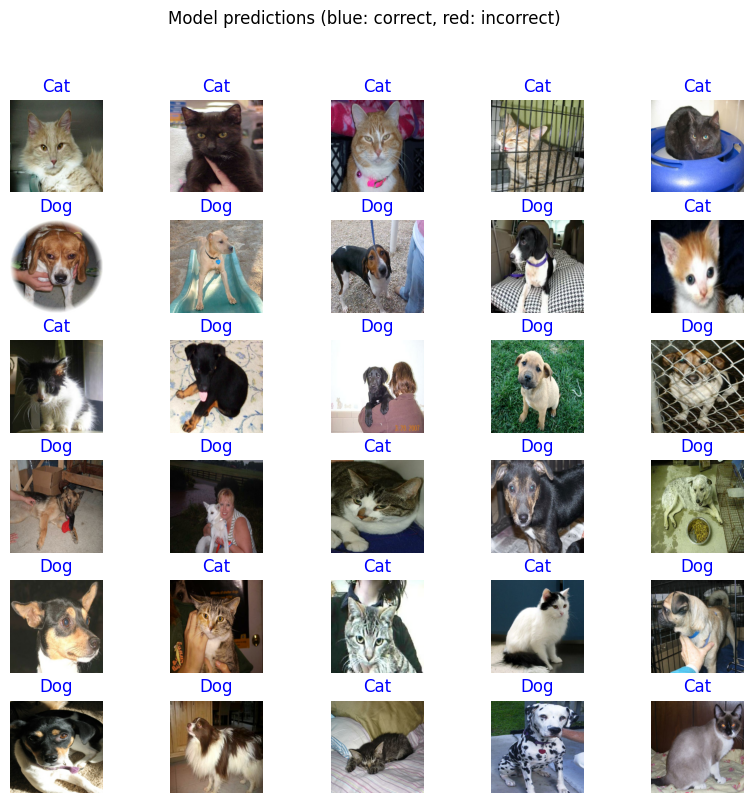

In [39]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")